## Some experimental results on the generation of AUID for optimal CUID sets

Required modules.

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import base64
import zlib
import hashlib
from networkx.generators.trees import NIL
from networkx.utils import generate_unique_node
import functools
import random

Auxiliary functions to generate different string representations from string sets.

In [3]:
def generate_BP(T, root, pars, root_name, nil_name, with_opening_par):
    """
    It returns a "balanced parenthesis" string representation of the tree T, including the source
    of the nodes (not only the parenthesis).
    :param pars: The style of parentheses can be chosen (a string with two chars, e.g. "()")
    :param root_name: The root node name can be chosen (string with one char).
    :param nil_name: The name for the nodes that are the string terminators in the tree/trie (string with one char)
    :param with_opening_par: You can choose if the BP has the opening parentheses or not (boolean). If you choose False
    the source parameter of the nodes of the Tree will be used instead (must be possible).    
    """
    assert(len(pars) == 2)
    assert(len(root_name) == 1)
    assert(len(nil_name) == 1)    
    
    def _generate_BP_node(T, node, pars, nil_name, with_opening_par):        
        pref = pars[0] if with_opening_par else ""
        # The NIL node is a terminator of each string in the preffix tree; I do need to include it in the BP representation
        # as it is the only way to distinguish the trie for [N123] and the trie for [N12,N123], for instance.
        if node != NIL:            
            s = pref + str(T.nodes[node]['source'])
            for son in T.adj[node]:
                s = s + _generate_BP_node(T, son, pars, nil_name, with_opening_par)
            s = s + pars[1]
        else:
            s = pref + nil_name + pars[1]
        return s
    
    pref = pars[0] if with_opening_par else ""
    s = pref + root_name
    for son in T.adj[root]:
        s = s + _generate_BP_node(T, son, pars, nil_name, with_opening_par)
    s = s + pars[1]
    return s
    

def hash_id(id, digest_size=20):
    """
    Takes an id (a string) and returns a blake2b hash with digest_size, encoded as
    a utf-8 urlsafe base64 encoded string
    """
    m = hashlib.blake2b(id.encode(), digest_size=digest_size)    
    hash_b64 = base64.urlsafe_b64encode(m.digest())
    return(hash_b64.decode("utf-8"))

def compress_id(id):
    """
    Returns a compression (zlib; as a bytes object) of id (must be a utf-8 string).
    """
    id_bytes = id.encode("utf-8")
    id_comp = zlib.compress(id_bytes)
    return id_comp
    
def decompress_id_bytes(id_bytes):   
    """
    Returns a utf-8 string which is id_bytes (bytes object) decompressed.
    """
    id_decomp = zlib.decompress(id_bytes)    
    return id_decomp.decode("utf-8")   

# Some tests
def test(cuids, pars):
    t,r = nx.prefix_tree(sorted(cuids))
    lbp = generate_BP(t,r, pars, root_name="R", nil_name="$", with_opening_par = False)
    lbpc = compress_id(lbp)
    assert decompress_id_bytes(lbpc) == lbp

    lbp = generate_BP(t,r, pars, root_name="R", nil_name="$", with_opening_par = True)
    lbpc = compress_id(lbp)
    assert decompress_id_bytes(lbpc) == lbp

test(['N1', 'N21', 'N22', 'N23', 'N25', 'N28', 'N3', 'N4', 'N6', 'N73', 'N76', 'N78', 'N83', 'N86', 'N88', 'N5231', 'N5232'], "{}")
test(['N1', 'N21', 'N22', 'N23', 'N25', 'N28', 'N3', 'N4', 'N6', 'N73', 'N76', 'N78', 'N83', 'N86', 'N88', 'N5231', 'N5232'], "()")
test(['[1,(0,0)]2', '[1,(0,1)]2', '[1,(1,1)]2'],"{}")
test(['[1,(0,0)]2', '[1,(0,1)]2', '[1,(1,1)]2'],"()")
test(['[1,(0,0)]2', '[1,(0,1)]2', '[1,(1,1)]2'],"[]")
test(['N(1,0)1', 'N(1,0)1', 'N(1,1)1', 'N(3,3)2', 'N(3,2)2', 'N(1,1)2', 'N(0,7)3', 'N(7,6)3', 'N(0,0)3', 
      'N(12,5)4', 'N(3,5)4', 'N(6,5)4', 'N(1,15)4', 'N(7,7)4', 'N(6,12)4', 'N(9,8)4', 'N(0,9)4'], "{}")
test(['N(1,0)1', 'N(1,0)1', 'N(1,1)1', 'N(3,3)2', 'N(3,2)2', 'N(1,1)2', 'N(0,7)3', 'N(7,6)3', 'N(0,0)3', 
      'N(12,5)4', 'N(3,5)4', 'N(6,5)4', 'N(1,15)4', 'N(7,7)4', 'N(6,12)4', 'N(9,8)4', 'N(0,9)4'], "()")

Auxiliary functions to generate a set of strings from its unique string representation.

In [4]:
def bp_auid_to_preffix_tree(bp_auid, pars, nil_name, with_opening_par):    
    # Init the tree with its root and the NIL "pseudo-leaf"
    t = nx.DiGraph()
    r = generate_unique_node()
    t.add_node(r, source=None)
    t.add_node(NIL, source=NIL)
    # And populate with the contents of lbp
    current_node = r
    populate_with_bp_auid(bp_auid, pars, nil_name, with_opening_par, t, r, True)    
    return (t, r)                    

def populate_with_bp_auid(bp_auid, pars, nil_name, with_opening_par, t, current_node, going_down):    
     while len(bp_auid) > 0:        
        if with_opening_par and bp_auid[0] == pars[0]:
            going_down = True
            node_source, bp_auid = process_node_source(bp_auid[1:], pars, nil_name, '')
            new_node = generate_unique_node()
            t.add_node(new_node, source = node_source)
            t.add_edge(current_node, new_node)
            current_node = new_node
        elif bp_auid[0] == pars[1]:            
            if going_down:                
                t.add_edge(current_node, NIL)
                going_down = False # Add NIL only as a leaf                        
            current_node = next(t.predecessors(current_node)) # The only parent, this is a tree            
            bp_auid = bp_auid[1:]                        
        else:            
            going_down = True            
            node_source = "" if bp_auid[0] == nil_name else bp_auid[0]          
            bp_auid = bp_auid[1:]            
            new_node = generate_unique_node()
            t.add_node(new_node, source = node_source)
            t.add_edge(current_node, new_node)
            current_node = new_node                            
        
def process_node_source(bp_auid, pars, nil_name, node_source):
    if bp_auid[0] != pars[0] and bp_auid[0] != bp_auid[1]:
        suf = "" if bp_auid[0] == nil_name else bp_auid[0]
        return process_node_source(bp_auid[1:], pars, nil_name, node_source + suf)
    else:
        return (node_source, bp_auid)
    raise ValueError("Parenthesis " + pars + " are not properly balanced in bp_auid")
    
    
def preffix_tree_to_ids(T, root):
    ids = []
    for node in T.predecessors(NIL):
        id = ''
        while node != root:
            id = str(T.node[node]['source']) + id
            node = next(T.predecessors(node))
        ids.append(id)        
    return sorted(ids)

The function `cuids_to_bp_auid` is the one you need to take a number of cell unique identifiers (CUIDs), create a trie (preffix tree) with them, and get a balanced parentheses string representation of that trie, along with a hash and a compressed version of that string.
The function `cuids_to_concat_auid` does the same thing, but the auid is just a concatenation of the CUIDs.

The function `bp_auid_to_cuids` is the one you need to take an area unique identifier (AUID) encoded as a balanced parenthesis string from a trie, and generate the cell unique identifiers (CUIDs) included in that area.

In [5]:
def cuids_to_bp_auid(cuids, pars="{}", root_name="R", nil_name="$", with_opening_par = False):
    """
    Takes a list of cell unique identifiers (cuids) and returns a tuple with:
    - A string representation of that list of cuids that can be used as an area unique identifier (AUID),
      based on a trie created from the sorted(cuids) and expressed as a balanced parenthesis string with or without the opening parenthesis        
    - A blake2b hash of that string.
    - A compressed version of that string (as a bytes object)
    - The trie (networkx object)
    - The root of the trie (networkx object)    
    """
    # Sorting the ids is necessary to prevent that for instance ['N21', 'N22'] and ['N22', 'N21'] give
    # different results    
    sorted_cuids = sorted(cuids)
    t, r = nx.prefix_tree(sorted_cuids) # A Prefix_Tree is essentially another name for a trie   
    auid = generate_BP(t, r, pars, root_name, nil_name, with_opening_par)       
    hashed = hash_id(auid)
    auid_compressed = compress_id(auid)    
    return (auid, hashed, auid_compressed, t, r)        

def cuids_to_concat_auid(cuids):
    """
    Takes a list of cell unique identifiers (cuids) and returns a tuple with:
    - A string representation of that list of cuids that can be used as an area unique identifier (AUID) based on a concatenation of the sorted(cuids)    
    - A blake2b hash of that string.
    - A compressed version of that string (as a bytes object)
    """
    sorted_cuids = sorted(cuids)
    auid = functools.reduce(lambda x,y: x+y, sorted_cuids) # Just concatenate the ids
    hashed = hash_id(auid)
    auid_compressed = compress_id(auid)
    return (auid, hashed, auid_compressed) 

def bp_auid_to_cuids(bp_auid, pars="{}", root_name='R', nil_name='$', with_opening_par=True):
    """
    Takes a string with a bp string auid and returns the list of ids that are encoded
    in that auid.
    """
    # The part with the root name in the bp_auid is irrelevant: it will always be our
    # root node (with source None) in the tree, and it does not change at all the area encoded    
    pref_len = 1 if with_opening_par else 0    
    t, r = bp_auid_to_preffix_tree(bp_auid[len(root_name)+pref_len:-1], pars, nil_name, with_opening_par)    
    return preffix_tree_to_ids(t,r)

Some tests.

In [8]:
# Some tests (cuids to bp_auid and reverse, and check it is the same)
def test_encode_decode(cuids):
    auid_bp, _, _, _, _ = cuids_to_bp_auid(cuids, with_opening_par = True)
    assert(bp_auid_to_cuids(auid_bp, with_opening_par = True) == cuids)
    auid_bp, _, _, _, _ = cuids_to_bp_auid(cuids, with_opening_par = False)
    assert(bp_auid_to_cuids(auid_bp, with_opening_par = False) == cuids)
    
def test_order_not_relevant(ids1, ids2):
    bp_auid1, _,_,_,_ = cuids_to_bp_auid(ids1)
    bp_auid2, _,_,_,_ = cuids_to_bp_auid(ids2)           
    assert(bp_auid1 == bp_auid2)
        
test_encode_decode(['N11', 'N12', 'N2', 'N3'])
test_encode_decode(['N1', 'N21', 'N22', 'N23', 'N25', 'S12', 'S13'])
test_encode_decode(["[1,(0,0)]2", "[1,(0,1)]2", "[1,(1,1)]2"])
test_encode_decode(["[1,(1,1)]1", "[1,(2,2)]2", "[1,(2,3)]2", "[1,(3,2)]2", "[1,(3,3)]2"])
test_encode_decode = ['N(1,0)1', 'N(1,0)1', 'N(1,1)1', 'N(3,3)2', 'N(3,2)2', 'N(1,1)2', 'N(0,7)3', 'N(7,6)3', 'N(0,0)3', 
                      'N(12,5)4', 'N(3,5)4', 'N(6,5)4', 'N(1,15)4', 'N(7,7)4', 'N(6,12)4', 'N(9,8)4', 'N(0,9)4']

test_order_not_relevant(['N22', 'N21'], ['N21', 'N22'])
test_order_not_relevant(['[1,(1,0)]1', '[1,(0,1)]2', '[1,(0,1)]2'], 
                        ['[1,(1,0)]1', '[1,(0,1)]2', '[1,(0,1)]2'])
    
    
# Quick examples
def show(ids):
    lbp, lbp_hashed, lbp_comp, _, _ = cuids_to_bp_auid(ids, with_opening_par=True)
    print("Balanced parenthesis tree representation: " + lbp)
    print("The hash: " + lbp_hashed)
    print("Compressed as bytes: " + str(lbp_comp))
    auid, auid_hashed, auid_comp = cuids_to_concat_auid(ids)
    print("Contatenation: " + auid)
    print("The hash: " + auid_hashed)
    print("Compressed as bytes: " + str(auid_comp))
    
def show_some_strings():
    show(['N1', 'N21', 'N22', 'N23', 'N25', 'S12', 'S13'])
    show(['[1,(0,0)]2', '[1,(0,1)]2', '[1,(1,1)]2'])

# Uncomment the next line to see some resulting strings
#show_some_strings()

### Generate random AUIDs and measure their size
The next cell contains the functions `generate_random_location_prefixBased` and `generate_random_location_axesBased`, plus two auxiliary ones, which are used to generate random sets of valid CUIDs encoded with two different strategies used in DGGSs.

In [11]:
def is_optimal_axesBased(cuids):
    """
    Returns True if cuids (a list of cell uids) is an optimal CUID set with an axes based cell encoding for the CUIDs.
    """
    def _mother_of(cid):
        # Returns the mother cell (at previous adjacent resolution) of cell cid
        # Requires that the reoslution of cid is at least 1 (fails otherwise)
        comps = cid.replace("[","").replace("]",",").replace("(","").replace(")","").split(",")
        res = int(comps[3])
        col = int(comps[1])
        row = int(comps[2])
        sqr = comps[0]        
        if res == 1:
            return sqr
        else:
            parent_col = col // 2
            parent_row = row // 2
            return "[" + sqr  + ",(" + str(parent_col) + "," + str(parent_row) + ")]" + str(res-1)         
    
    # Repetitions means not optimal
    if len(set(cuids)) != len(cuids):
        return False
    
    # Not optimal if a cell and any of its daughters appear (only the mother is necessary)
    for id1 in cuids:
        for id2 in cuids:
            if id1 != id2:
                # We are already comparing every id to every other id in the fors, so we do not need
                # to check if id1 is mother of id2 or viceversa in this if
                if _mother_of(id1) == id2: 
                    return False    

    # Not optimal if the daughters of a given cell appear 4 times, because then that cell (the mother)
    # should have been there instead
    mothers = {}
    for id in cuids:
        mother = _mother_of(id)
        if mother in mothers:
            mothers[mother] += 1      
            if mothers[mother] == 4:
                return False
        else:
            mothers[mother] = 1                        
    return True
        

def is_optimal_with_prefix(cuids, n_side):
    """
    Returns True if cuids (a list of cell uids) is an optimal CUID set with preffix based (rHEALPix style) encoding for the CUIDs.
    n_side can be 2 or 3 (a cell is divided into 4 or into 9 at the next resolution level)
    """
    # Not optimal if any id is a substring of any other (eg. N1 and N12 is suboptimal, because N1 includes N12)    
    # This catches repetitions too (e.g N1 and again N1 is suboptimal)
    sorted_cuids = sorted(cuids)        
    for i in range(len(cuids)):
        for j in range(i+1, len(cuids)):
            # startsWith is not conmutative but the ids are sorted, so you just need to compare "forward"
            if sorted_cuids[j].startswith(sorted_cuids[i]):
                return False

    # Not optimal if, e.g., N11, N12, N13 and N14 are there, because N1 should be instead (at this point it
    # is not there, because that would have been detected in the previous steps)
    # Not optimal either if N111, N112, N113, N114, N121, N122, ..., N144 because N1 should be there instead.                
    # The preffixes dictionary captures these non optimalities:
    # We are counting how many times each prefix of exactly one character less (i.e. [:-1]) appears
    # So, if entry N1 appears 4 times in the dictionary, it means that N11, N12, N13, N14 have appeared (if n_side==2)
    # And if entry N11 appears 4 times, it means that N111, N112, N113, N114 have appeared (if n_side==2)
    # As we can't complete a cell at resolution 2 with cells at resolution, say, 4, without completing
    # cells at resolution 3 first, we just need to check adjacent resolutions, and thus the [:-1] preffixes
    # For instance if we have N111, N112, N113, N114, N121, N122, ..., N144, N1 should be there, but also N11,N12,N13 and N14
    preffixes = {}
    for id in sorted_cuids:
        pref = id[:-1]        
        if pref in preffixes:
            preffixes[pref] += 1
            if preffixes[pref] == n_side * n_side:
                return False
        else:
            preffixes[pref] = 1    
    return True


def generate_random_location_prefixBased(num, res1, res2, n_side=2, must_be_optimal=False):
    """
    Generate a list of num cell ids between resolutions res1 and res2 (both included), assumin
    a preffix based (rHEALPix style) encoding for the cell ids with n_side (must be 2 or 3).
    1. Random and unsorted.    
    2. Not an optimal CUID set unless must_be_optimal=True
    if must_be_optimal, this function may not terminate (i.e. if you request "too many" different
    cells)
    """
    def _generator(n_side, num, res1, res2):
        for n in range(num):
            square = random.choice(["N", "S", "O", "P", "Q", "R"])
            cellid = square
            resolution = random.choice(range(res1, res2+1))        
            for i in range(1, resolution+1):
                cellid = cellid + str(random.choice(range(n_side*n_side)))
            yield cellid
    
    cellids = list(_generator(n_side, num, res1, res2))
    if must_be_optimal: # Try until optimal. Not efficient (indeed it may be *very slow* if num is large-ish).
        while not is_optimal_with_prefix(cellids, n_side):
            cellids = list(_generator(n_side, num, res1, res2))    
    return cellids


def generate_random_location_axesBased(num, res1, res2, must_be_optimal=False):
    """
    Generate a list of num cell ids between resolutions res1 and res2 (both included), assuming
    an axes based encoding for the cell ids:
    1. Random and unsorted.    
    2. Not an optimal CUID set unless must_be_optimal=True
    if must_be_optimal, this function may not terminate (i.e. if you request "too many" different
    cells)
    """    
    def _generator(num, res1, res2):
        for n in range(num):
            square = random.choice(["1", "2", "3", "4", "5", "6"])            
            resolution = random.choice(range(res1, res2+1))
            col = random.choice(range(2**resolution))
            row = random.choice(range(2**resolution))                    
            cellid = "[" + square  + ",(" + str(col) + "," + str(row) + ")]" + str(resolution) 
            yield cellid
    
    cellids = list(_generator(num, res1, res2))    
    if must_be_optimal: # Try until optimal. Not efficient (indeed it may be *very slow* if num is large-ish).
        while not is_optimal_axesBased(cellids):
            cellids = list(_generator(num, res1, res2))    
    return cellids    
    
# Some tests
assert is_optimal_with_prefix(["N151", "N14", "N1523"], 2)
assert not is_optimal_with_prefix(["N1", "N1"], 3)
assert not is_optimal_with_prefix(["N111", "N112", "N113", "N114", "S141", "S143"], 2)
assert not is_optimal_with_prefix(["N421", "N3", "N112", "N113", "N422", "N5421", "N111", "N423", "N422", "N114", "N424"], 2)
assert not is_optimal_axesBased(["[1,(0,0)]9", "[1,(0,0)]9"])
assert is_optimal_axesBased(["[1,(0,0)]2", "[1,(0,1)]2", "[1,(1,1)]2"])
assert not is_optimal_axesBased(["[1,(0,0)]1", "[1,(0,0)]2", "[1,(0,1)]2", "[1,(1,1)]2"])
assert not is_optimal_axesBased(["[1,(0,0)]1", "[1,(0,0)]2", "[1,(0,1)]2", "[1,(1,0)]2", "[1,(1,1)]2"])
assert not is_optimal_axesBased(["[1,(1,1)]1", "[1,(2,2)]2", "[1,(2,3)]2", "[1,(3,2)]2", "[1,(3,3)]2"])

# To see some results, uncomment the next lines
#print(generate_random_location_axesBased(10, 3, 5, must_be_optimal=True))
#print(generate_random_location_prefixBased(10, 3,6, n_side=3, must_be_optimal = True))        

### Figures and other results shown on the paper

Generate and print the BP strings for the example CUID set in the paper

In [12]:
auid,_,_,_,_ = cuids_to_bp_auid(["N11", "N12", "N2", "N3"], pars="()", with_opening_par=True)
print(auid)
short_auid,_,_,_,_ = cuids_to_bp_auid(["N11", "N12", "N2", "N3"], pars="()", with_opening_par=False)
print(short_auid)
hashed_auid = hash_id(short_auid, digest_size=32)
print(hashed_auid)

(R(N(1(1($))(2($)))(2($))(3($))))
RN11$))2$)))2$))3$))))
Cv45YMXIP0nWPbHFXtnVVYK2TJkwp3xh6ZQxPb8QqPs=


A function to generate a number of AUIDs for different combinations of DGGS indexing strategy, min and max resolutions...

In [14]:
def generate_random_auids(reps, addressing_type, n_cells, res1, res2, must_be_optimal, pars, n_side=2):        
    """
    Generate reps random AUIDs for the given combination of parameters (addressing type, number of cells,
    resolutions...) and return as a DataFrame some data statistics as pandas data frame with a single
    row. The rows includes the averages of the lengths of the different generated potential AUIDs.
    """
    sum_len_concat = 0
    sum_len_bp = 0
    sum_len_bp_short = 0
    sum_len_concat_comp = 0
    sum_len_bp_comp = 0
    sum_len_bp_short_comp = 0
    
    data = {'addressing_type' : [], 'n_side': [], 'must_be_optimal': [], 'pars': [], 'n_cells': [], 
            'res1': [], 'res2': [], 'len_concat': [], 'len_bp': [], 'len_bp_short': [], 
            'len_concat_comp': [], 'len_bp_comp': [], 'len_bp_short_comp': []}
    
    for i in range(reps):
        # Generate random sets of n_cells CUIDs 
        if (addressing_type == "axis"):
            cuids = generate_random_location_axesBased(n_cells, res1, res2, must_be_optimal)
            n_side = -1 # to make it clear in the results that it does not apply
        elif (addressing_type == "prefix"):
            cuids = generate_random_location_prefixBased(n_cells, res1, res2, n_side, must_be_optimal)
        else:
            raise ValueError(f"Unknown addressing_type ({addresing_type})")
        
        # Create the AUIDs with the different strategies
        bp_auid,_,bp_auid_comp,_,_ = cuids_to_bp_auid(cuids, pars, with_opening_par=True)        
        bp_auid_short,_,bp_auid_short_comp,_,_ = cuids_to_bp_auid(cuids, pars, with_opening_par=False)        
        concat_auid,_,concat_auid_comp, = cuids_to_concat_auid(cuids) # Concatenate the ids                        
        
        # Sum the lenghts of the different AUIDs generated
        sum_len_concat += len(concat_auid)
        sum_len_bp += len(bp_auid)
        sum_len_bp_short += len(bp_auid_short)
        sum_len_concat_comp += len(concat_auid_comp)
        sum_len_bp_comp += len(bp_auid_comp)
        sum_len_bp_short_comp += len(bp_auid_short_comp)
        
    data['addressing_type'].append(addressing_type)
    data['n_side'].append(n_side)
    data['must_be_optimal'].append(must_be_optimal)
    data['pars'].append(pars)
    data['n_cells'].append(n_cells)
    data['res1'].append(res1)
    data['res2'].append(res2)
    # The lengths returned in the dataframe are the averages over all repetitions
    data['len_concat'].append(sum_len_concat/reps)
    data['len_bp'].append(sum_len_bp/reps)
    data['len_bp_short'].append(sum_len_bp_short/reps)
    data['len_concat_comp'].append(sum_len_concat_comp/reps)
    data['len_bp_comp'].append(sum_len_bp_comp/reps)
    data['len_bp_short_comp'].append(sum_len_bp_short_comp/reps)
    return pd.DataFrame(data)

# Show an example
def show_result_of_generate_random_auids():
    df = generate_random_auids(6, "axis", 100, 6, 8, False, "{}", 2)
    return df
# Uncomment the next line to see an example of a generated dataframe
#show_result_of_generate_random_auids()   

Generate the figure on the paper. It takes a few minutes. It will prouduce a single file `figures.png` in your working directory. If you uncomment the last line, it will also generate a `results.csv` file, in the same directory, with some results in a format that you can manipulate with any software.

Finished generating axis, 6, 9...
Finished generating axis, 6, 12...
Finished generating axis, 9, 12...
Finished generating prefix, 6, 9...
Finished generating prefix, 6, 12...
Finished generating prefix, 9, 12...
Finished generating prefix, 6, 9...
Finished generating prefix, 6, 12...
Finished generating prefix, 9, 12...
Finished generating axis, 9, 12...
Finished generating prefix, 9, 12...
Finished generating prefix, 9, 12...
16598.4
15743.977777777776
13694.733333333332
For the axis-based ids, the lenght of the compressed AUIDs based on the BP short version is
on average a 82.50634599318809% of the compressed concatenation.
12642.566666666666
12146.966666666667
10851.544444444444
For the prefix-based ids with n_side 2, the lenght of the compressed AUIDs based on the BP short version is
on average a 85.83339705105593% of the compressed concatenation.
19237.2
21106.855555555554
18592.822222222218
For the prefix-based ids with n_side 3, the lenght of the compressed AUIDs based on the 

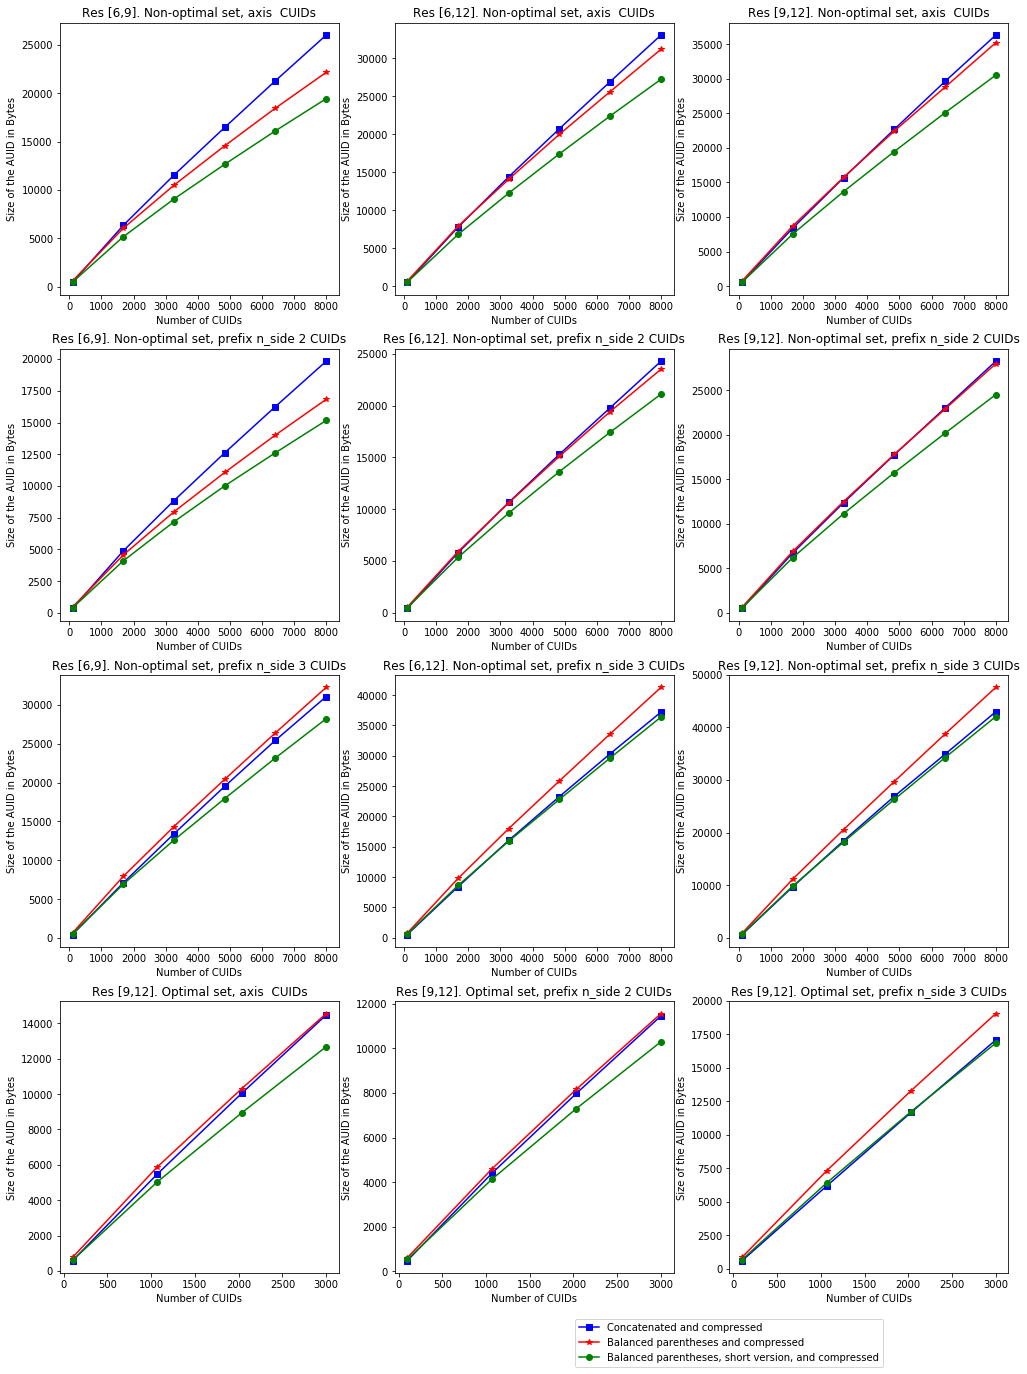

In [15]:
# to make sure that you can replicate the results in the paper we fix a random seed. You can comment this line 
# to produce more random results
random.seed(1234)

def generate_data(num, addressing_type, n_cells_from, n_cells_to, res1, res2, must_be_optimal, pars, n_side):    
    data_frames = []
    # Example:
    # If n_cells_from is 100, n_cells_to is 200, num is 2 and reps is 5,
    # we will generate a data frame with 2 rows.
    # For the first row, we will generate 5 random sets of valid CUIDs with 100 cell ids each, create their AUIDs with the different
    # options (concatenation, BP, BP short, compressed and not compressed versions) and will average the
    # lengths of those AUIDs over those 5 repetions
    # For the second row the same, but with a CUID set of 200 cell ids        
    reps = 5 
    for n_cells in np.linspace(n_cells_from, n_cells_to, num, dtype=np.int32):                
        data_frames.append(generate_random_auids(reps, addressing_type, n_cells, res1, res2, must_be_optimal, pars, n_side))        
    print(f"Finished generating {addressing_type}, {res1}, {res2}...") # To see some advance while it is working
    return pd.concat(data_frames)

def generate_all_paper_data(test):
    if test:
        maxcells = 1000
        num = 2 # number of samples in the [mincells,maxcells] range
        maxcells_optimal_axis = 500
        maxcells_optimal = 1500        
        num_optimal = 2
    else:
        maxcells = 8000
        num = 6
        # The optimal versions are far slower and, with the wrong parameters, they are not guaranteed to end        
        # so for now we need to limit the number of cells generated and the number of tests
        maxcells_optimal_axis = 3000
        maxcells_optimal = 3000
        num_optimal = 4
    
    data_frames_axis = []
    data_frames_prefix_n2 = []
    data_frames_prefix_n3 = []
    data_frames_axis_optimal = []
    data_frames_prefix_n2_optimal = []    
    data_frames_prefix_n3_optimal = []    
    
    data_frames_axis.append(generate_data(num, "axis", 100, maxcells, res1 = 6, res2 = 9, must_be_optimal=False, pars="{}", n_side=2))    
    data_frames_axis.append(generate_data(num, "axis", 100, maxcells, res1 = 6, res2 = 12, must_be_optimal=False, pars="{}", n_side=2))
    data_frames_axis.append(generate_data(num, "axis", 100, maxcells, res1 = 9, res2 = 12, must_be_optimal=False, pars="{}", n_side=2))    

    data_frames_prefix_n2.append(generate_data(num, "prefix", 100, maxcells, res1 = 6, res2 = 9, must_be_optimal=False, pars="{}", n_side=2))
    data_frames_prefix_n2.append(generate_data(num, "prefix", 100, maxcells, res1 = 6, res2 = 12, must_be_optimal=False, pars="{}", n_side=2))
    data_frames_prefix_n2.append(generate_data(num, "prefix", 100, maxcells, res1 = 9, res2 = 12, must_be_optimal=False, pars="{}", n_side=2))    

    data_frames_prefix_n3.append(generate_data(num, "prefix", 100, maxcells, res1 = 6, res2 = 9, must_be_optimal=False, pars="{}", n_side=3))
    data_frames_prefix_n3.append(generate_data(num, "prefix", 100, maxcells, res1 = 6, res2 = 12, must_be_optimal=False, pars="{}", n_side=3))
    data_frames_prefix_n3.append(generate_data(num, "prefix", 100, maxcells, res1 = 9, res2 = 12, must_be_optimal=False, pars="{}", n_side=3))    

    # We use higher resolutions and less number of cell uids to minimize the risk of repeating those 
    # CUIDs in the random generation. With lower resolutions and more cells it is far slower, and even
    # possible that it can't end.    
    data_frames_axis_optimal.append(generate_data(num_optimal, "axis", 100, maxcells_optimal_axis, res1 = 9, res2 = 12, must_be_optimal=True, pars="{}", n_side=2))    
        
    data_frames_prefix_n2_optimal.append(generate_data(num_optimal, "prefix", 100, maxcells_optimal, res1 = 9, res2 = 12, must_be_optimal=True, pars="{}", n_side=2))    
    
    data_frames_prefix_n3_optimal.append(generate_data(num_optimal, "prefix", 100, maxcells_optimal, res1 = 9, res2 = 12, must_be_optimal=True, pars="{}", n_side=3))    
    
    return (data_frames_axis, data_frames_prefix_n2, data_frames_prefix_n3, 
            data_frames_axis_optimal, data_frames_prefix_n2_optimal, data_frames_prefix_n3_optimal)
 
def plot(df):    
    d0 = df.iloc[0] # General things for the plot can be taken from the first row
    optimal_string = "Optimal set" if d0.must_be_optimal else "Non-optimal set"
    nside_string = f"n_side {d0.n_side}" if d0.addressing_type == "prefix" else ""    
    
    plt.title(f"Res [{d0.res1},{d0.res2}]. {optimal_string}, {d0.addressing_type} {nside_string} CUIDs")   
    plt.xlabel("Number of CUIDs")
    plt.ylabel("Size of the AUID in Bytes")
    
    plt.plot(df.n_cells, df.len_concat_comp, "bs-", label="Concatenated and compressed") # o cicles, s squares, d diamonds...
    plt.plot(df.n_cells, df.len_bp_comp,"r*-", label="Balanced parentheses and compressed")
    plt.plot(df.n_cells, df.len_bp_short_comp, "go-", label="Balanced parentheses, short version, and compressed")    
    

def paper_data_and_diagrams(test):
    dfs_axis, dfs_prefix2, dfs_prefix3, dfs_axis_optimal, dfs_prefix2_optimal, dfs_prefix3_optimal = generate_all_paper_data(test)
    
    df_axis = pd.concat(dfs_axis)    
    df_prefix2 = pd.concat(dfs_prefix2)    
    df_prefix3 = pd.concat(dfs_prefix3)
    df_axis_optimal = pd.concat(dfs_axis_optimal)    
    df_prefix2_optimal = pd.concat(dfs_prefix2_optimal)
    df_prefix3_optimal = pd.concat(dfs_prefix3_optimal)
    
    fig = plt.figure(figsize=(17,23))
    plt.subplot(431)
    plot(dfs_axis[0])
    plt.subplot(432)
    plot(dfs_axis[1])
    plt.subplot(433)
    plot(dfs_axis[2])    
   
    plt.subplot(434)
    plot(dfs_prefix2[0])
    plt.subplot(435)
    plot(dfs_prefix2[1])
    plt.subplot(436)
    plot(dfs_prefix2[2])    
    
    plt.subplot(437)
    plot(dfs_prefix3[0])
    plt.subplot(438)
    plot(dfs_prefix3[1])
    plt.subplot(439)
    plot(dfs_prefix3[2])    
    
    plt.subplot(4,3,10)
    plot(dfs_axis_optimal[0])
    plt.subplot(4,3,11)
    plot(dfs_prefix2_optimal[0])
    plt.subplot(4,3,12)
    plot(dfs_prefix3_optimal[0])
    plt.legend(loc='upper center', bbox_to_anchor=(0, -0.15),
              fancybox=True, ncol=1)
    plt.savefig("figures.png", dpi=150)
       
    
    print(f"{df_axis.len_concat_comp.mean()}")
    print(f"{df_axis.len_bp_comp.mean()}")
    print(f"{df_axis.len_bp_short_comp.mean()}")
    print(f"For the axis-based ids, the lenght of the compressed AUIDs based on the BP short version is\n"
          f"on average a {df_axis.len_bp_short_comp.mean()*100/df_axis.len_concat_comp.mean()}% of the compressed concatenation.")
    print(f"{df_prefix2.len_concat_comp.mean()}")
    print(f"{df_prefix2.len_bp_comp.mean()}")
    print(f"{df_prefix2.len_bp_short_comp.mean()}")
    print(f"For the prefix-based ids with n_side 2, the lenght of the compressed AUIDs based on the BP short version is\n"
          f"on average a {df_prefix2.len_bp_short_comp.mean()*100/df_prefix2.len_concat_comp.mean()}% of the compressed concatenation.")
    print(f"{df_prefix3.len_concat_comp.mean()}")
    print(f"{df_prefix3.len_bp_comp.mean()}")
    print(f"{df_prefix3.len_bp_short_comp.mean()}")
    print(f"For the prefix-based ids with n_side 3, the lenght of the compressed AUIDs based on the BP short version is\n"
          f"on average a {df_prefix3.len_bp_short_comp.mean()*100/df_prefix3.len_concat_comp.mean()}% of the compressed concatenation.")
    
    print(f"{df_axis_optimal.len_concat_comp.mean()}")
    print(f"{df_axis_optimal.len_bp_comp.mean()}")
    print(f"{df_axis_optimal.len_bp_short_comp.mean()}")
    print(f"For the axis-based ids optimal, the lenght of the compressed AUIDs based on the BP short version is\n"
          f"on average a {df_axis_optimal.len_bp_short_comp.mean()*100/df_axis_optimal.len_concat_comp.mean()}% of the compressed concatenation.")    
    print(f"{df_prefix2_optimal.len_concat_comp.mean()}")
    print(f"{df_prefix2_optimal.len_bp_comp.mean()}")
    print(f"{df_prefix2_optimal.len_bp_short_comp.mean()}")
    print(f"For the prefix-based ids with n_side 2 and optimal, the lenght of the compressed AUIDs based on the BP short version is\n"
          f"on average a {df_prefix2_optimal.len_bp_short_comp.mean()*100/df_prefix2_optimal.len_concat_comp.mean()}% of the compressed concatenation.")
    print(f"{df_prefix3_optimal.len_concat_comp.mean()}")
    print(f"{df_prefix3_optimal.len_bp_comp.mean()}")
    print(f"{df_prefix3_optimal.len_bp_short_comp.mean()}")
    print(f"For the prefix-based ids with n_side 3 and optimal, the lenght of the compressed AUIDs based on the BP short version is\n"
          f"on average a {df_prefix3_optimal.len_bp_short_comp.mean()*100/df_prefix3_optimal.len_concat_comp.mean()}% of the compressed concatenation.")
    
    return pd.concat(dfs_axis+dfs_prefix2+dfs_prefix3+dfs_axis_optimal+dfs_prefix2_optimal+dfs_prefix3_optimal)
    
    
df = paper_data_and_diagrams(test=False) # use test=True to check that it works; with test=False, you get the final results, but 
# it takes longer to finish.

# Uncomment the next line to save as a CSV for further analysis with other software
# df.to_csv(path_or_buf='results.csv')